<a href="https://colab.research.google.com/github/mertcan-basut/nlp/blob/main/classification_and_vector_spaces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import PCA
from sklearn.metrics import log_loss

import matplotlib.pyplot as plt
import random

import re
import string

import nltk
nltk.download("twitter_samples")
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer

[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Feature Extraction with Frequencies

- **Preprocessing**
  - Eliminate handles and URLs
  - Tokenize the string into words
  - Remove stop words (and, is, a, on, etc.) and punctuation
  - Stemming
  - Convert all words to lower case
- Create vocabulary from corpus
- **Feature extraction**
  - Create a dictionary to map the word, and the class it appeared in
  - `X = [bias, sum of (+) freqs., sum of (-) freqs.]`
  - `Y = positive (1) or negative (0)`

In [108]:
positive_tweets = nltk.corpus.twitter_samples.strings("positive_tweets.json")
negative_tweets = nltk.corpus.twitter_samples.strings("negative_tweets.json")
data = pd.DataFrame(data={"tweet": positive_tweets + negative_tweets, "sentiment": [1]*len(positive_tweets) + [0]*len(negative_tweets)})
data.head()

,tweet,sentiment
0,#FollowFriday @France_Inte @PKuchly57 @Milipol...,1
1,@Lamb2ja Hey James! How odd :/ Please call our...,1
2,@DespiteOfficial we had a listen last night :)...,1
3,@97sides CONGRATS :),1
4,yeaaaah yippppy!!! my accnt verified rqst has...,1


In [115]:
r = 0.2

random.shuffle(positive_tweets)
t = int(len(positive_tweets)*r)
positive_tweets_train = positive_tweets[t:]
positive_tweets_test = positive_tweets[:t]

random.shuffle(negative_tweets)
t = int(len(negative_tweets)*r)
negative_tweets_train = negative_tweets[t:]
negative_tweets_test = negative_tweets[:t]

data_train = pd.DataFrame(data={"tweet": positive_tweets_train + negative_tweets_train, "sentiment": [1]*len(positive_tweets_train) + [0]*len(negative_tweets_train)})
data_test = pd.DataFrame(data={"tweet": positive_tweets_test + negative_tweets_test, "sentiment": [1]*len(positive_tweets_test) + [0]*len(negative_tweets_test)})

In [116]:
stopwords_english = stopwords.words('english')
punctuations = string.punctuation

def pre_process(tweet):
  tweet_stripped = re.sub(r'^RT[\s]+', '', tweet) # remove old style retweet text "RT"
  tweet_stripped = re.sub(r'https?://[^\s\n\r]+', '', tweet_stripped) # remove hyperlinks
  tweet_stripped = re.sub(r'#', '', tweet_stripped) # remove hashtags

  tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
  tokens = tokenizer.tokenize(tweet_stripped)

  tokens_stripped = [word for word in tokens if word not in stopwords_english and word not in punctuations]

  stemmer = PorterStemmer()
  stems = [stemmer.stem(word) for word in tokens_stripped]

  return stems

data_train["tweet_processed"] = data_train["tweet"].apply(pre_process)
data_train.head()

,tweet,sentiment,tweet_processed
0,@Tulki Any help / advice / info you need - jus...,1,"[help, advic, info, need, yell, :), normal, ca..."
1,@marthasydenham @alexxdouglas @wordpressdotcom...,1,"[love, stuff, need, repeat, relentlessli, appr..."
2,@joiredve follback :D,1,"[follback, :d]"
3,@davidrmoloney thanks for that. You've made my...,1,"[thank, made, day, :), let', organis, meet, so..."
4,@cabbyyyy ..is doing a Harry dm giveaway nooow...,1,"[.., harri, dm, giveaway, nooow, :), ♥, ★, ☆]"


In [117]:
def create_vocabulary(data):
  vocabulary = {}
  for index, row in data.iterrows():
    tweet = row["tweet_processed"]
    sentiment = row["sentiment"]
    for word in tweet:
      if word not in vocabulary:
        vocabulary[word] = [0, 0] # create vocabulary
      if sentiment == 1:
        vocabulary[word][0] += 1 # positive
      elif sentiment == 0:
        vocabulary[word][1] += 1 # negative
  return vocabulary

vocabulary = create_vocabulary(data_train)

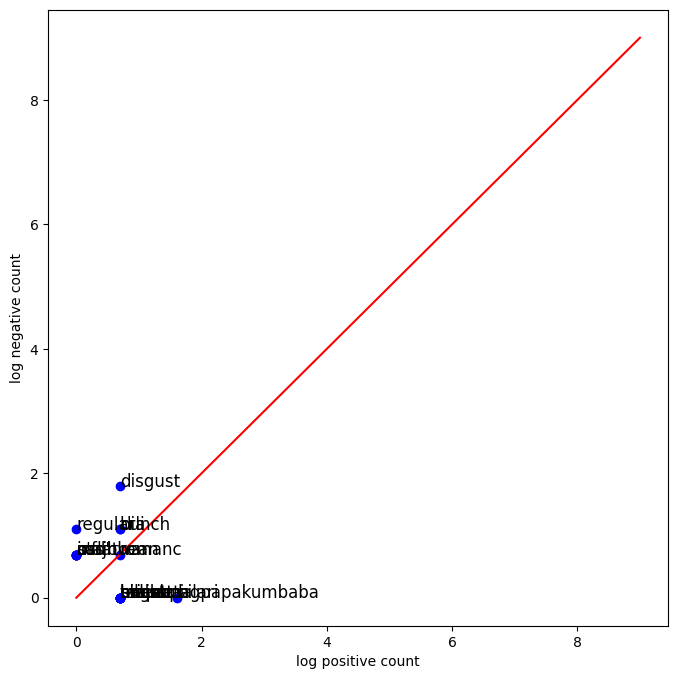

In [118]:
fig, ax = plt.subplots(figsize=(8, 8))
for word, freqs in random.sample(list(vocabulary.items()), 20):
  x = np.log(freqs[0] + 1)
  y = np.log(freqs[1] + 1)
  ax.scatter(x, y, c='blue')
  ax.annotate(word, (x, y), fontsize=12)
ax.plot([0, 9], [0, 9], color='red')
plt.xlabel("log positive count")
plt.ylabel("log negative count")
plt.show()

In [119]:
def frequency(tweet_processed):
  positive_freq = 0
  negative_freq = 0
  for word in tweet_processed:
    positive_freq += vocabulary.get(word, (0,0))[0]
    negative_freq += vocabulary.get(word, (0,0))[1]
  return positive_freq, negative_freq

data_train[["positive_freq", "negative_freq"]] = data_train.apply(lambda x: frequency(x["tweet_processed"]), axis=1, result_type='expand')
data_train.head()

,tweet,sentiment,tweet_processed,positive_freq,negative_freq
0,@Tulki Any help / advice / info you need - jus...,1,"[help, advic, info, need, yell, :), normal, ca...",3321,312
1,@marthasydenham @alexxdouglas @wordpressdotcom...,1,"[love, stuff, need, repeat, relentlessli, appr...",3463,288
2,@joiredve follback :D,1,"[follback, :d]",538,1
3,@davidrmoloney thanks for that. You've made my...,1,"[thank, made, day, :), let', organis, meet, so...",3815,303
4,@cabbyyyy ..is doing a Harry dm giveaway nooow...,1,"[.., harri, dm, giveaway, nooow, :), ♥, ★, ☆]",3143,132


In [122]:
X_train = data_train[["positive_freq", "negative_freq"]]
y_train = data_train["sentiment"]

model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

data_test["tweet_processed"] = data_test["tweet"].apply(pre_process)
data_test[["positive_freq", "negative_freq"]] = data_test.apply(lambda x: frequency(x["tweet_processed"]), axis=1, result_type='expand')
X_test = data_test[["positive_freq", "negative_freq"]]
y_test = data_test["sentiment"]

print("training_accuracy: ", model_lr.score(X_train, y_train))
print("testing_accuracy: ", model_lr.score(X_test, y_test))
print("training_cross-entropy loss: ", log_loss(y_train, model_lr.predict_proba(X_train)))
print("testing_cross-entropy loss: ", log_loss(y_test, model_lr.predict_proba(X_test)))

training_accuracy:  0.992625
testing_accuracy:  0.995
training_cross-entropy loss:  0.02684377418262317
testing_cross-entropy loss:  0.012463357569957869


In [163]:
tweet = "Very good, thanks :)"
features = np.array(frequency(pre_process(tweet)))
X = pd.DataFrame(data={"positive_freq":features[0], "negative_freq":features[1]}, index=[0])
class_ = model_lr.predict(X)
print("positive" if class_==1 else "negative")
print("probability: ", model_lr.predict_proba(X)[0][class_][0])

positive
probability:  0.9999999999999076


## TF-IDF Vectorization (word by document)

- **Term Frequency(TF)**

  It is a measure of the frequency of a word (w) in a document (d). TF is defined as the ratio of a word’s occurrence in a document to the total number of words in a document.

  `TF(w,d) = occurances of w in d / total number of words in d`

- **Inverse Document Frequency(IDF)**

  It is the measure of the importance of a word providing weightage to each word based on its frequency in the corpus D.

  `IDF(w,D) = ln( total number of documents (N) in D / number of documents containing w` )

- **Term Frequency — Inverse Document Frequency(TFIDF)**

  Gives more weightage to the word that is rare in the corpus and provides more importance to the word that is more frequent in the document. Documents can be represented as a TFIDF vector of dimension equal to the vocabulary words. The value corresponding to each word represents the importance of that word in a particular document.

  `TFIDF(w,d,D) = TF(w,d) * IDF(w,D)`

In [166]:
data_train = data_train[["tweet", "sentiment", "tweet_processed"]]
data_test = data_test[["tweet", "sentiment", "tweet_processed"]]

vocabulary = data_train["tweet_processed"].apply(pd.Series).stack().unique()

In [167]:
a = len(data_train["tweet_processed"])
b = lambda word: np.count_nonzero(data_train["tweet_processed"].apply(lambda x: x.count(word) ))
idf = np.array([np.log( a/b(word) ) for word in vocabulary])

In [171]:
data_train["tf"] = data_train["tweet_processed"].apply(lambda x: np.array([x.count(word)/len(x) for word in vocabulary]) )
data_train["tfidf"] = data_train["tf"].apply(lambda x: x * idf)
data_train.head()

,tweet,sentiment,tweet_processed,tf,tfidf
0,@Tulki Any help / advice / info you need - jus...,1,"[help, advic, info, need, yell, :), normal, ca...","[0.08333333333333333, 0.08333333333333333, 0.0...","[0.38170646444980993, 0.6148132423523227, 0.54..."
1,@marthasydenham @alexxdouglas @wordpressdotcom...,1,"[love, stuff, need, repeat, relentlessli, appr...","[0.0, 0.0, 0.0, 0.1, 0.0, 0.1, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.40173835210859726, 0.0, 0.10..."
2,@joiredve follback :D,1,"[follback, :d]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,@davidrmoloney thanks for that. You've made my...,1,"[thank, made, day, :), let', organis, meet, so...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.1031771731749301, ..."
4,@cabbyyyy ..is doing a Harry dm giveaway nooow...,1,"[.., harri, dm, giveaway, nooow, :), ♥, ★, ☆]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.1111111111111111, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.11464130352770009,..."


explained-variance:  0.012938852634537529


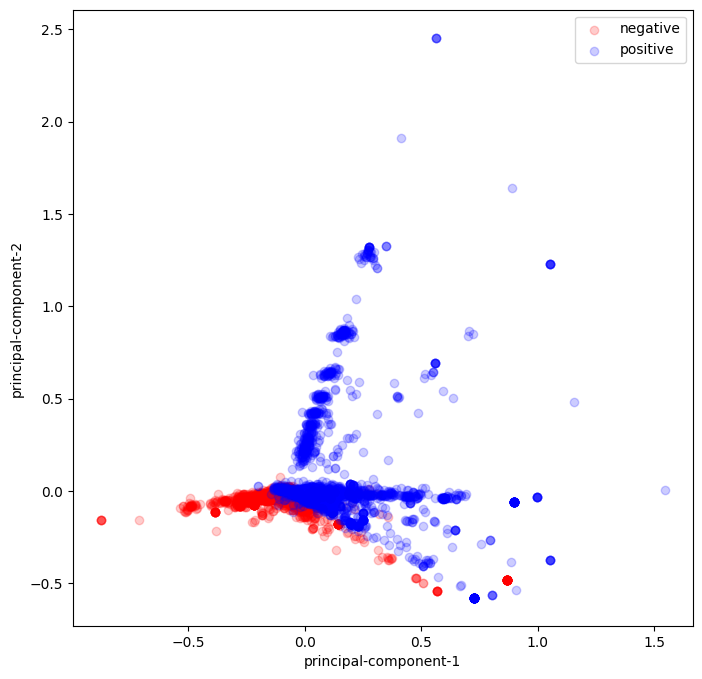

In [173]:
X = np.stack(data_train["tfidf"].values)
y = data_train["sentiment"]
pca = PCA(n_components=2)
pca.fit(X)
x = pca.fit_transform(X)
print("explained-variance: ", sum(pca.explained_variance_ratio_))

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(x[y==0,0], x[y==0,1], c='red', alpha=0.2, label='negative')
ax.scatter(x[y==1,0], x[y==1,1], c='blue', alpha=0.2, label='positive')
ax.legend()
plt.xlabel("principal-component-1")
plt.ylabel("principal-component-2")
plt.show()

In [178]:
X_train = np.stack(data_train["tfidf"].values)
y_train = data_train["sentiment"]

model_nb = MultinomialNB()
model_nb.fit(X_train, y_train)

data_test["tf"] = data_test["tweet_processed"].apply(lambda x: np.array([x.count(word)/len(x) for word in vocabulary]) )
data_test["tfidf"] = data_test["tf"].apply(lambda x: x * idf)
X_test = np.stack(data_test["tfidf"].values)
y_test = data_test["sentiment"]

print("training_accuracy: ", model_nb.score(X_train, y_train))
print("testing_accuracy: ", model_nb.score(X_test, y_test))
print("training_cross-entropy loss: ", log_loss(y_train, model_nb.predict_proba(X_train)))
print("testing_cross-entropy loss: ", log_loss(y_test, model_nb.predict_proba(X_test)))

training_accuracy:  0.976625
testing_accuracy:  0.899
training_cross-entropy loss:  0.09205180278185332
testing_cross-entropy loss:  0.25373765506700197


In [189]:
tweet = "Very bad, I'm sad :("
tweet_processed = pre_process(tweet)
X = np.array([tweet_processed.count(word)/len(tweet_processed) for word in vocabulary]) * idf
class_ = model_nb.predict([X])
print("positive" if class_==1 else "negative")
print("probability: ", model_nb.predict_proba([X])[0][class_][0])

negative
probability:  0.9989388998466051
